### Compute the score for each edge based on the embedding of the two nodes
Only consider connected graph\
The score is computed using the distance of the two vectors, and would be large if the embeddings are different.

In [1]:
import torch
import torch.nn.functional as F


from torch.nn import PairwiseDistance
import torch_geometric.transforms as T
import torch_geometric.utils as U
from torch_geometric.data import Data

import networkx as nx
from cluster import *

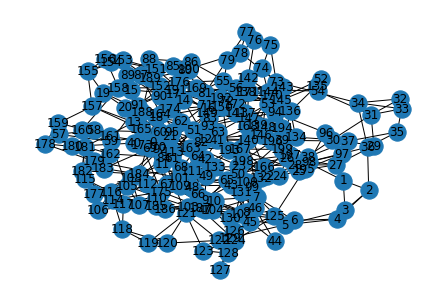

In [9]:
import networkx as nx 
n = 200
G = nx.connected_watts_strogatz_graph(n, k=4, p=0.4)
nx.draw(G, with_labels=True)
G0 = U.from_networkx(G)
edge_index = G0.edge_index
G0.x = torch.randn(n,3) # feature_size = 3
x = G0.x

In [10]:
def compute_score(score_method=0.5, normalize = True, edge_index=torch.tensor([]), x=torch.tensor([]), self_add=0.5):
    if score_method in [int, float]:
        pdist = PairwiseDistance(score_method)
        edge_score = pdist(x[edge_index[0]], x[edge_index[1]])
    else:
        in_channels = x.shape[1]
        lin = torch.nn.Linear(2*in_channels, 1)
        e = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1) 
        edge_score = lin(e).view(-1)
    if normalize == True:
        if torch.max(edge_score)!=torch.min(edge_score):
            edge_score = (edge_score - torch.min(edge_score)) / (torch.max(edge_score) - torch.min(edge_score))
        else: 
            edge_score = torch.ones(x.shape[0],1) * 1/x.shape[0]
    return edge_score+self_add
# test
edge_score = compute_score(score_method='lin', normalize = True, edge_index=edge_index, x=x, self_add=0.5)
print(torch.min(edge_score))
print(torch.max(edge_score))

tensor(0.5000, grad_fn=<MinBackward1>)
tensor(1.5000, grad_fn=<MaxBackward1>)


In [11]:
def node_cluster_search(edge_score, upper_bound, edge_index, i, greedy=False):
    selected_score = torch.tensor([])
    in_cluster = torch.tensor([i])
    selected_edge = torch.tensor([])
    while (sum(selected_score) < upper_bound):
        potential_edge_index = torch.tensor([])
        potential_score = torch.tensor([])
        # all the edges that start from node within cluster, end with node outside the cluster
        for i in in_cluster:
            potential_edge_index = torch.cat([potential_edge_index, edge_index[:,edge_index[0]==i]], dim=-1) 
            potential_score = torch.cat([potential_score, edge_score[edge_index[0]==i]], dim=-1)
    
        for j in in_cluster:
            # score need to be chaned before edge_index
            potential_score = potential_score[potential_edge_index[1]!=j]
            potential_edge_index = potential_edge_index[:,potential_edge_index[1]!=j]
            
        if (potential_score.shape[0] == 0):
            raise Exception("The current cluster contained all nodes")

        # will add one node randomly if several edges have the same values
        add_score = torch.min(potential_score,dim=0,keepdim=True).values
        add_edge = potential_edge_index[:,torch.where(potential_score==add_score)[0]]
        selected_edge = torch.cat([selected_edge, add_edge], dim=-1)   
        selected_score = torch.cat([selected_score, add_score], dim=-1)

        in_cluster = torch.cat([in_cluster, add_edge[1]], dim=-1)    
    if (greedy==False):
        num = in_cluster.shape[0]-1
        in_cluster = in_cluster[0:num]
        selected_edge = selected_edge[:,0:num]
        selected_score = selected_score[0:0:num]
    return in_cluster

# test 
node_cluster_search(edge_score, upper_bound=3, edge_index=edge_index, i=2, greedy=False)

tensor([2., 3., 4., 1.])

In [12]:
# node_score o(E)
def get_node_score(edge_score=torch.tensor([]), edge_index=torch.tensor([])):
    num_nodes = torch.max(edge_index) + 1
    node_min_score = torch.tensor([])
    node_max_score = torch.tensor([])
    node_avg_score = torch.tensor([])
    node_score_dict = {}
    # Initialize dict 
    for i in range(num_nodes):
        node_score_dict[i] = torch.tensor([])
    for i in range(edge_score.shape[0]):
        node_score_dict[edge_index[0,i].item()] = torch.cat([node_score_dict[edge_index[0,i].item()], edge_score[i,None]], 0)
        node_score_dict[edge_index[1,i].item()] = torch.cat([node_score_dict[edge_index[1,i].item()], edge_score[i,None]], 0)
    for i in range(num_nodes):
        node_min_score = torch.cat([node_min_score, torch.min(node_score_dict[i], dim=0, keepdim=True).values], 0)
        node_max_score = torch.cat([node_max_score, torch.max(node_score_dict[i], dim=0, keepdim=True).values], 0)
        node_avg_score = torch.cat([node_avg_score, torch.mean(node_score_dict[i], dim=0, keepdim=True)], 0)
    return node_min_score, node_max_score, node_avg_score
    
node_min_score, node_max_score, node_avg_score = get_node_score(edge_score, edge_index)

In [13]:
def cluster_assignment(edge_score, edge_index, upper_bound, aggregate_score, greedy=False, select=True):
    num_cluster = num_nodes = torch.max(edge_index) + 1
    assignment_matrix = torch.zeros((num_cluster, num_nodes))
    node_score_matrix = torch.zeros([num_cluster, num_nodes])

    for i in range(num_cluster):
        in_cluster = node_cluster_search(edge_score, upper_bound, edge_index, i=i, greedy=greedy)
        for j in in_cluster:
            assignment_matrix[i,j.numpy()] = 1
            node_score_matrix[i,j.numpy()] = aggregate_score[j.numpy()]

    # delete repeated cluster
    _, index, _ = np.unique(assignment_matrix.numpy(), return_index=True, return_inverse=True, axis=0)
    assignment_matrix = assignment_matrix[index,]
    node_score_matrix = node_score_matrix[index,]
    
    if select == True:
        selected_assignment_matrix = torch.tensor([])
        selected_node_score_matrix = torch.tensor([])
        potential_assignment_matrix = assignment_matrix
        potential_node_score_matrix = node_score_matrix
        
        potential_node_index = torch.ones(num_nodes) # node index that hasn't been selected
        while (torch.sum(torch.sum(selected_assignment_matrix, dim=0)>0) < num_nodes):
            num_of_element = torch.sum(potential_assignment_matrix[:,potential_node_index>0], dim=1)
            selected_cluster_index = torch.where(num_of_element==torch.max(num_of_element))[0][0]
            selected_assignment_matrix = torch.cat([selected_assignment_matrix, potential_assignment_matrix[selected_cluster_index,:][None,:]], dim=0)
            selected_node_score_matrix = torch.cat([selected_node_score_matrix, potential_node_score_matrix[selected_cluster_index,:][None,:]], dim=0)
            # remove the select cluster from potential clusters
            potential_assignment_matrix = torch.cat([potential_assignment_matrix[0:selected_cluster_index,:],potential_assignment_matrix[selected_cluster_index+1:,:]],dim=0)
            potential_node_score_matrix = torch.cat([potential_node_score_matrix[0:selected_cluster_index,:],potential_node_score_matrix[selected_cluster_index+1:,:]],dim=0)
            potential_node_index[torch.sum(selected_assignment_matrix, dim=0)>0] = 0
    else:
        selected_assignment_matrix = assignment_matrix
        selected_node_score_matrix = node_score_matrix
    return selected_assignment_matrix, selected_node_score_matrix 

# Test
selected_assignment_matrix, selected_node_score_matrix  = cluster_assignment(edge_score, edge_index, upper_bound=2, aggregate_score=node_avg_score, greedy=False, select=True)


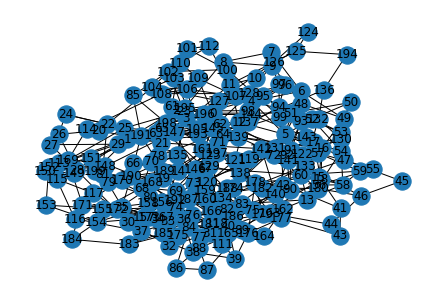

In [14]:
import networkx as nx 
n = 200
G = nx.connected_watts_strogatz_graph(n, k=4, p=0.4)
nx.draw(G, with_labels=True)
G0 = U.from_networkx(G)
edge_index = G0.edge_index
G0.x = torch.randn(n,3) # feature_size = 3
x = G0.x

In [17]:
edge_score = compute_score(score_method='lin', normalize = True, edge_index=edge_index, x=x, self_add=0.5)
node_min_score, node_max_score, node_avg_score = get_node_score(edge_score, edge_index)
selected_assignment_matrix, selected_node_score_matrix  = cluster_assignment(edge_score, edge_index, upper_bound=2, greedy=False, select=True, aggregate_score=node_avg_score)

adj = U.to_dense_adj(edge_index)[0]
adj_new = torch.matmul(torch.matmul(selected_assignment_matrix,adj),selected_assignment_matrix.t()) # connectivity relationship
adj_new[adj_new>0] = 1
edge_index_new = U.remove_self_loops(U.dense_to_sparse(adj_new)[0])[0]
x_new = torch.matmul(selected_node_score_matrix, x)

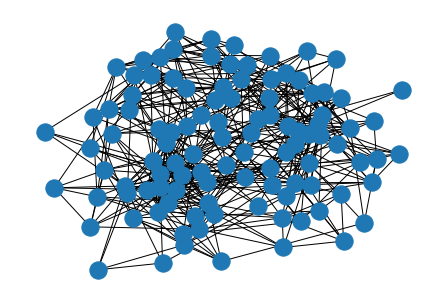

In [18]:
data = Data(x=x_new, edge_index=edge_index_new)
G_new = U.to_networkx(data, to_undirected=True)
nx.draw(G_new)